Target frame (adjusted for doubled frame count): 2
Frame dimensions: Width=1280, Height=720
Label: traffic light, Coordinates: x=978, y=42, w=66, h=128, Frame Width: 1280, Frame Height: 720
Label: traffic light, Coordinates: x=485, y=277, w=16, h=25, Frame Width: 1280, Frame Height: 720
Label: traffic sign, Coordinates: x=1094, y=114, w=118, h=92, Frame Width: 1280, Frame Height: 720
Label: traffic sign, Coordinates: x=148, y=216, w=24, h=29, Frame Width: 1280, Frame Height: 720
Label: traffic sign, Coordinates: x=935, y=312, w=19, h=22, Frame Width: 1280, Frame Height: 720
Label: traffic light, Coordinates: x=146, y=251, w=35, h=24, Frame Width: 1280, Frame Height: 720
Label: traffic light, Coordinates: x=823, y=292, w=22, h=22, Frame Width: 1280, Frame Height: 720
Label: traffic light, Coordinates: x=934, y=261, w=37, h=36, Frame Width: 1280, Frame Height: 720
Label: crashed car, Coordinates: x=389, y=333, w=113, h=58, Frame Width: 1280, Frame Height: 720
Label: car, Coordinates: x=9

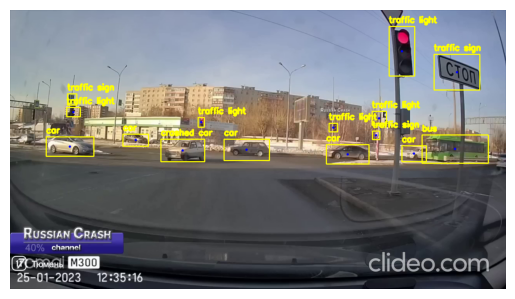

In [103]:
import json
import cv2
import matplotlib.pyplot as plt

def load_json_annotations(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

def draw_bounding_boxes(frame, boxes, labels, frame_width, frame_height):
    for box, label in zip(boxes, labels):
        # Scale the coordinates as specified
        x = int(box['x'] * 12.75)
        y = int(box['y'] * 7.3)
        w = int(box['width'] * 12.9)
        h = int(box['height'] * 6.7) 

        print(f"Label: {label}, Coordinates: x={x}, y={y}, w={w}, h={h}, Frame Width: {frame_width}, Frame Height: {frame_height}")
        
        # Check if the box falls within frame bounds
        if x < 0 or y < 0 or x + w > frame_width or y + h > frame_height:
            print(f"Bounding box for {label} is out of bounds and will not be drawn.")
            continue

        # Draw the bounding box
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)
        # Draw the center point of the bounding box
        center_x, center_y = x + w // 2, y + h // 2
        cv2.circle(frame, (center_x, center_y), 3, (255, 0, 0), -1)  # Blue center point for reference
        # Put the label text
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 3)
    return frame

def show_frame_with_boxes(video_path, json_path, frame_number=1):
    # Load JSON annotation data
    annotations = load_json_annotations(json_path)
    
    # Find the specific video data and bounding boxes
    for item in annotations:
        if item['video'] in video_path:
            boxes_info = item['box']
            break
    else:
        print("No matching video data found.")
        return
    
    # Multiply the frame number by 2 to account for the discrepancy
    target_frame_number = frame_number * 2
    print(f"Target frame (adjusted for doubled frame count): {target_frame_number}")
    
    # Load the video and retrieve the specific frame
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame_number - 1)
    ret, frame = cap.read()
    
    if not ret:
        print("Error reading frame.")
        cap.release()
        return
    
    # Get frame dimensions
    frame_height, frame_width = frame.shape[:2]
    print(f"Frame dimensions: Width={frame_width}, Height={frame_height}")

    # Draw bounding boxes for objects detected in the chosen frame
    for obj in boxes_info:
        for seq in obj['sequence']:
            if seq['frame'] == frame_number:  # Match with original frame number in JSON
                frame = draw_bounding_boxes(frame, [seq], obj['labels'], frame_width, frame_height)
    
    # Convert BGR to RGB for display with matplotlib
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    plt.imshow(frame)
    plt.axis('off')
    plt.show()
    cap.release()

# Example usage
video_path = '/kaggle/input/car-crash-dataset-russia-2022-2023/dataset/video/w10_10.mp4'
json_path = '/kaggle/input/car-crash-dataset-russia-2022-2023/dataset/label/json/w10_10.json'
show_frame_with_boxes(video_path, json_path, frame_number=1)


In [104]:
import json
import os
from collections import defaultdict

def count_short_sequences_and_classes(json_folder_path):
    video_counter = 0  # Number of videos with objects having fewer than 10 frames
    total_short_objects = 0  # Total number of objects with fewer than 10 frames
    total_long_objects = 0  # Total number of objects with 10 or more frames
    all_short_objects_video_counter = 0  # Number of videos where all objects have fewer than 10 frames
    unique_classes = set()  # Set to store unique object classes
    class_counts = defaultdict(int)  # Dictionary to count each class label
    no_label_objects = 0
    num_videos = 0

    # Iterate over each JSON file in the folder
    for json_file in os.listdir(json_folder_path):
        if json_file.endswith('.json'):
            num_videos += 1
            json_path = os.path.join(json_folder_path, json_file)
            
            # Load JSON annotation data
            with open(json_path, 'r') as f:
                data = json.load(f)
            
            short_object_found_in_video = False  # Flag to count videos with any short objects
            all_short = True  # Assume all objects are short initially

            # Check each detected object in the JSON file
            for item in data:
                video_name = item.get('video', 'Unknown video')
                for obj in item['box']:
                    num_frames = len(obj['sequence'])  # Number of frames in this object's sequence

                    # Add the object's label to the unique_classes set and update class_counts
                    if 'labels' in obj:
                        for label in obj['labels']:
                            unique_classes.add(label)
                            class_counts[label] += 1  # Increment count for this label
                    else:
                        no_label_objects += 1

                    if num_frames < 10:
                        total_short_objects += 1
                        short_object_found_in_video = True
                    else:
                        total_long_objects += 1
                        all_short = False

            # If we found at least one short object in this video, increment video counter
            if short_object_found_in_video:
                video_counter += 1
            
            # If all objects in this video are short, increment the all_short counter
            if all_short:
                all_short_objects_video_counter += 1
    
    # Print summary
    print(f"\nSummary:")
    print(f"Total number of videos: {num_videos}")
    print(f"Total number of videos with objects having fewer than 10 frames: {video_counter}")
    print(f"Total number of objects with fewer than 10 frames: {total_short_objects}")
    print(f"Total number of objects with 10 or more frames: {total_long_objects}")
    print(f"Total number of videos where all objects have fewer than 10 frames: {all_short_objects_video_counter}")
    print(f"nc: {len(unique_classes)}")
    print(f"names: {list(unique_classes)}")
    print(f"No label objects: {no_label_objects}")
    
    print("\nClass counts:")
    for label, count in class_counts.items():
        print(f"{label}: {count}")
        
# Example usage
json_folder_path = '/kaggle/input/car-crash-dataset-russia-2022-2023/dataset/label/json'
count_short_sequences_and_classes(json_folder_path)


Summary:
Total number of videos: 548
Total number of videos with objects having fewer than 10 frames: 456
Total number of objects with fewer than 10 frames: 3095
Total number of objects with 10 or more frames: 2787
Total number of videos where all objects have fewer than 10 frames: 48
nc: 31
names: ['traffic sign', 'bus', 'crowd', 'Bus', 'rider', 'tram', 'trailer', 'truck', 'crashed truck', 'obstruction', 'car', 'motorcycle', 'a vehicle', 'group of cars', 'crosswalk', 'traffic light', 'deliveryman', 'animal', 'bicycle', 'traffic controller', 'pedestrian', 'tractor', 'ambulance', 'Crosswalk', 'crashed car', 'object', 'train', 'Car', 'group of pedestrians', 'crashed motorcycle', 'crashed bus']
No label objects: 1

Class counts:
crashed car: 695
Bus: 4
traffic light: 341
traffic sign: 1318
car: 2657
crosswalk: 124
group of cars: 165
bus: 68
truck: 164
pedestrian: 169
Car: 129
train: 2
tractor: 2
trailer: 1
crashed truck: 1
a vehicle: 1
motorcycle: 4
obstruction: 1
traffic controller: 1
g

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = {
    'traffic sign': 1318, 'bus': 68, 'crowd': 2, 'Bus': 4, 'rider': 5,
    'tram': 3, 'trailer': 1, 'truck': 164, 'crashed truck': 1, 'obstruction': 1,
    'car': 2657, 'motorcycle': 4, 'a vehicle': 1, 'group of cars': 165,
    'crosswalk': 124, 'traffic light': 341, 'deliveryman': 1, 'animal': 8,
    'bicycle': 6, 'traffic controller': 1, 'pedestrian': 169, 'tractor': 2,
    'ambulance': 1, 'Crosswalk': 1, 'crashed car': 695, 'object': 1, 
    'train': 2, 'Car': 129, 'group of pedestrians': 3, 'crashed motorcycle': 1, 
    'crashed bus': 2
}
total_short_objects = 3095
total_long_objects = 2787
video_counter = 456
num_videos = 548
all_short_objects_video_counter = 48

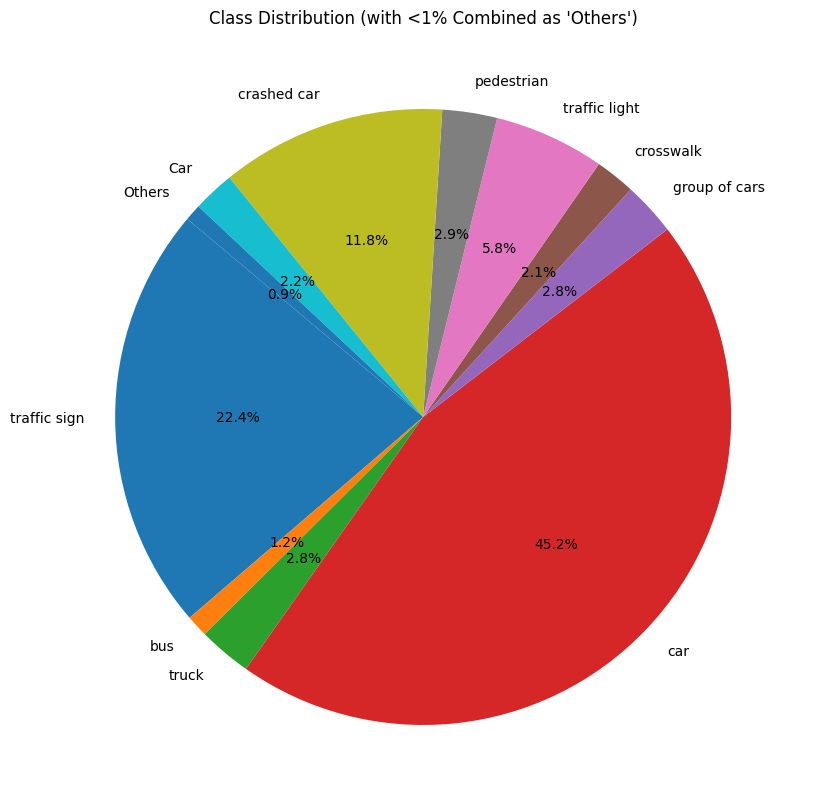

In [116]:
import matplotlib.pyplot as plt

# Define threshold for "Others" category (1% of total count)
threshold = sum(class_counts.values()) * 0.01

# Separate classes into "Others" if their count is below the threshold
main_classes = {label: count for label, count in class_counts.items() if count >= threshold}
others_count = sum(count for count in class_counts.values() if count < threshold)

# Add "Others" to the main_classes dictionary
main_classes["Others"] = others_count

# Plot the pie chart
plt.figure(figsize=(10, 10))
plt.pie(main_classes.values(), labels=main_classes.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Class Distribution (with <1% Combined as 'Others')")
plt.show()


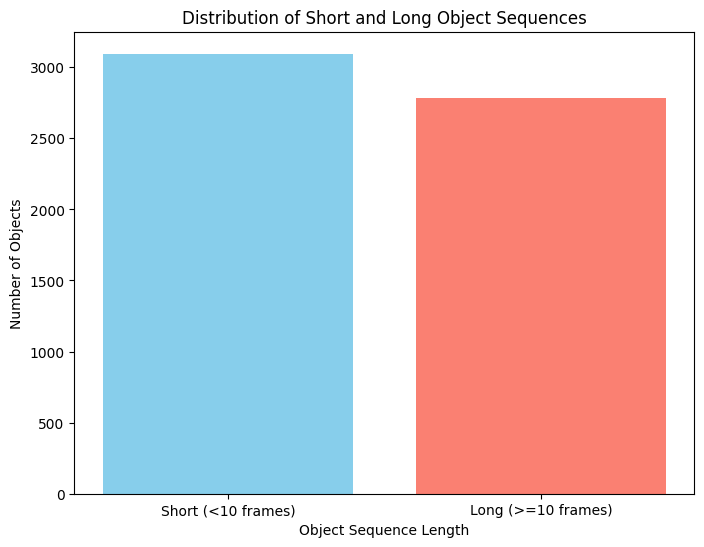

In [112]:
frame_lengths = ["Short (<10 frames)", "Long (>=10 frames)"]
frame_counts = [total_short_objects, total_long_objects]

plt.figure(figsize=(8, 6))
plt.bar(frame_lengths, frame_counts, color=["skyblue", "salmon"])
plt.xlabel("Object Sequence Length")
plt.ylabel("Number of Objects")
plt.title("Distribution of Short and Long Object Sequences")
plt.show()


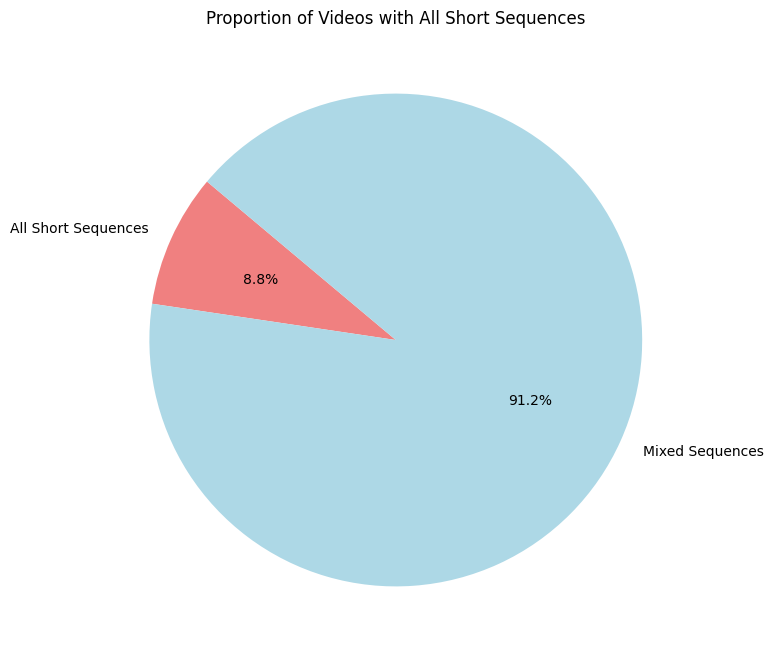

In [115]:
video_categories = ['All Short Sequences', 'Mixed Sequences']
video_counts = [all_short_objects_video_counter, num_videos - all_short_objects_video_counter]

plt.figure(figsize=(8, 8))
plt.pie(video_counts, labels=video_categories, autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightblue'])
plt.title("Proportion of Videos with All Short Sequences")
plt.show()


In [105]:
import json
import os
import shutil

def clean_json_and_csv_data(json_folder_path, csv_folder_path, cleaned_json_folder_path, cleaned_csv_folder_path):
    # Create cleaned folders if they don't exist
    os.makedirs(cleaned_json_folder_path, exist_ok=True)
    os.makedirs(cleaned_csv_folder_path, exist_ok=True)

    # Iterate over each JSON file in the folder
    for json_file in os.listdir(json_folder_path):
        if json_file.endswith('.json'):
            json_path = os.path.join(json_folder_path, json_file)
            csv_file = json_file.replace('.json', '.csv')  # Corresponding CSV file name
            csv_path = os.path.join(csv_folder_path, csv_file)

            # Load JSON annotation data
            with open(json_path, 'r') as f:
                data = json.load(f)
            
            cleaned_data = []  # Store cleaned annotations
            all_objects_short = True  # Flag to check if all objects are short

            for item in data:
                # For each object in the video, filter out short sequences and those without labels
                cleaned_boxes = []
                
                for obj in item['box']:
                    num_frames = len(obj['sequence'])
                    
                    # Check if the object has a label and at least 10 frames
                    if num_frames >= 10 and 'labels' in obj and obj['labels']:
                        cleaned_boxes.append(obj)  # Add to cleaned list
                        all_objects_short = False

                # Only add video entry if there are any cleaned objects left
                if cleaned_boxes:
                    item['box'] = cleaned_boxes
                    cleaned_data.append(item)

            # If all objects in the video are short, skip copying this video and its CSV file
            if all_objects_short:
                print(f"Excluding video: {json_file} (all objects have fewer than 10 frames)")
                continue

            # Save the cleaned data to the new folder
            cleaned_json_path = os.path.join(cleaned_json_folder_path, json_file)
            with open(cleaned_json_path, 'w') as f:
                json.dump(cleaned_data, f, indent=4)

            # Copy the corresponding CSV file to the cleaned folder if it exists
            if os.path.exists(csv_path):
                shutil.copy(csv_path, cleaned_csv_folder_path)

# Example usage
json_folder_path = '/kaggle/input/car-crash-dataset-russia-2022-2023/dataset/label/json'
csv_folder_path = '/kaggle/input/car-crash-dataset-russia-2022-2023/dataset/label/csv'
cleaned_json_folder_path = '/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/json'
cleaned_csv_folder_path = '/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/csv'

clean_json_and_csv_data(json_folder_path, csv_folder_path, cleaned_json_folder_path, cleaned_csv_folder_path)

Excluding video: w10_62.json (all objects have fewer than 10 frames)
Excluding video: w10_85.json (all objects have fewer than 10 frames)
Excluding video: w10_73.json (all objects have fewer than 10 frames)
Excluding video: w3_29.json (all objects have fewer than 10 frames)
Excluding video: w10_124.json (all objects have fewer than 10 frames)
Excluding video: w10_136.json (all objects have fewer than 10 frames)
Excluding video: w10_72.json (all objects have fewer than 10 frames)
Excluding video: w10_88.json (all objects have fewer than 10 frames)
Excluding video: w10_128.json (all objects have fewer than 10 frames)
Excluding video: w6_23.json (all objects have fewer than 10 frames)
Excluding video: w10_77.json (all objects have fewer than 10 frames)
Excluding video: w10_154.json (all objects have fewer than 10 frames)
Excluding video: w10_82.json (all objects have fewer than 10 frames)
Excluding video: w10_98.json (all objects have fewer than 10 frames)
Excluding video: w10_157.json (a

In [106]:
json_folder_path = '/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/json'
count_short_sequences_and_classes(json_folder_path)


Summary:
Total number of videos: 500
Total number of videos with objects having fewer than 10 frames: 0
Total number of objects with fewer than 10 frames: 0
Total number of objects with 10 or more frames: 2786
Total number of videos where all objects have fewer than 10 frames: 0
nc: 27
names: ['traffic sign', 'bus', 'crowd', 'rider', 'Bus', 'tram', 'trailer', 'truck', 'crashed truck', 'car', 'motorcycle', 'a vehicle', 'group of cars', 'crosswalk', 'traffic light', 'deliveryman', 'animal', 'bicycle', 'traffic controller', 'pedestrian', 'tractor', 'crashed car', 'object', 'train', 'Car', 'crashed motorcycle', 'crashed bus']
No label objects: 0

Class counts:
traffic light: 133
traffic sign: 536
crashed car: 502
car: 1236
pedestrian: 70
Car: 96
Bus: 3
crashed motorcycle: 1
group of cars: 54
truck: 82
rider: 2
crashed bus: 2
bus: 31
crosswalk: 18
traffic controller: 1
crashed truck: 1
tram: 2
a vehicle: 1
object: 1
bicycle: 2
trailer: 1
animal: 3
motorcycle: 3
crowd: 1
tractor: 2
delivery

In [107]:
import json
import os

# Define label mappings for the classes we want to retain
label_mappings = {
    "car": "car",
    "Car": "car",
    "truck": "car",
    "bus": "car",
    "Bus": "car",
    "tram": "car",
    "a vehicle": "car",
    "crashed car": "crashed",
    "crashed motorcycle": "crashed",
    "crashed bus": "crashed",
    "crashed truck": "crashed"
}

def clean_and_count_classes(json_folder_path, output_folder_path):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder_path, exist_ok=True)
    
    # Dictionary to count each class label
    class_counts = {"car": 0, "crashed": 0}
    
    # Iterate over each JSON file in the folder
    for json_file in os.listdir(json_folder_path):
        if json_file.endswith('.json'):
            json_path = os.path.join(json_folder_path, json_file)
            
            # Load JSON annotation data
            with open(json_path, 'r') as f:
                data = json.load(f)
            
            # Cleaned data to store only valid objects
            cleaned_data = []
            
            # Process each video in the JSON data
            for item in data:
                cleaned_boxes = []
                
                # Filter the "box" list to retain only desired classes
                for obj in item['box']:
                    valid_labels = []
                    
                    # Map labels according to the specified mappings and filter
                    for label in obj.get('labels', []):
                        if label in label_mappings:
                            mapped_label = label_mappings[label]
                            valid_labels.append(mapped_label)
                            class_counts[mapped_label] += 1
                    
                    # Keep the object only if it has a valid label
                    if valid_labels:
                        obj['labels'] = valid_labels
                        cleaned_boxes.append(obj)
                
                # Add cleaned objects to the item
                item['box'] = cleaned_boxes
                cleaned_data.append(item)
            
            # Save the cleaned data to the new folder
            cleaned_json_path = os.path.join(output_folder_path, json_file)
            with open(cleaned_json_path, 'w') as f:
                json.dump(cleaned_data, f, indent=4)

# Example usage
json_folder_path = '/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/json'
output_folder_path = '/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/json'
clean_and_count_classes(json_folder_path, output_folder_path)

In [108]:
json_folder_path = '/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/json'
count_short_sequences_and_classes(json_folder_path)


Summary:
Total number of videos: 500
Total number of videos with objects having fewer than 10 frames: 0
Total number of objects with fewer than 10 frames: 0
Total number of objects with 10 or more frames: 1957
Total number of videos where all objects have fewer than 10 frames: 3
nc: 2
names: ['car', 'crashed']
No label objects: 0

Class counts:
crashed: 506
car: 1451


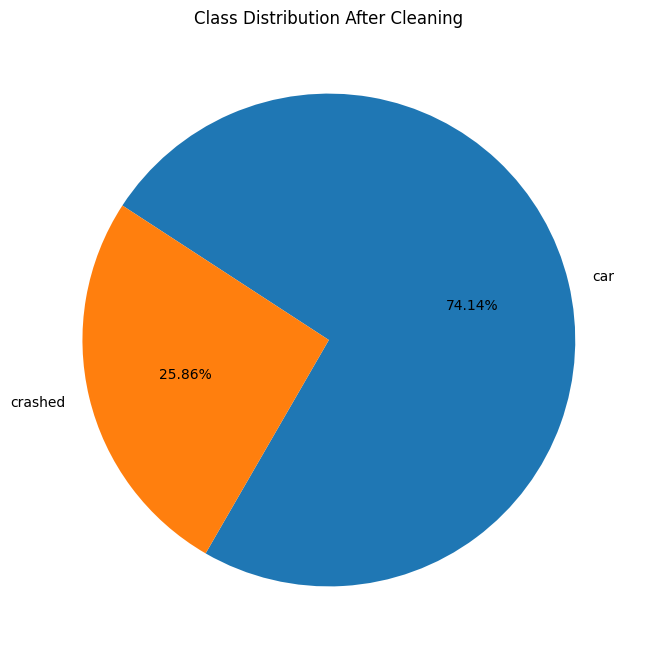

In [122]:
import matplotlib.pyplot as plt

# Data for the cleaned class counts
class_counts = {
    "car": 1451,
    "crashed": 506
}

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.2f%%', startangle=240)
plt.title("Class Distribution After Cleaning")
plt.show()
